# Grade: /100 pts

# Assignment 06: Regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import t


pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: Preprocessing (5 pts)
**Make sure to only use the imports included in the first cell. Any additional imports used will result in 0.** <br>
Tasks:
* Load the data present in 'footballer_small.csv' using the pandas library and store the loaded data in a dataframe
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0 <br>

In [2]:
# Loading data, dropping unnecessary variables, dummy coding categorical variables.
model_data = pd.read_csv("footballer_small.csv")
model_data = model_data.drop(columns=['ID', 'club', 'club_logo', 'flag', 'nationality', 'photo', 'potential', 'birth_date'])
model_data = pd.get_dummies(model_data, drop_first=False)

# Getting predictor and outcome variables, splitting into train and test.
X = model_data.drop(columns="overall")
y = model_data.overall
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 500, random_state = 0)

## Question 2: Building the pipeline that preprocesses the data (10 pts)
In order to properly build the regression model, the features need to be standardized so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build the pipeline that preprocesses the feature columns of the training data and create a linear regression model. Plot the data before and after the standardization for the stamina feature. <br>
In this question, there is no need to overwrite the training set's values. Create a new variable to include the standardized data. The original training data is needed for future exercises. <br>
### Question
Make observations about the plot.  

"Written answer: the plots appear to have the same distribution shape (minus some difference because of different bins for each plot), however the standardized plot is centred around 0 with a stdev of 1, whereas the unstandardized one is centred around the mean of stamina with a stdev of stamina's stdev."

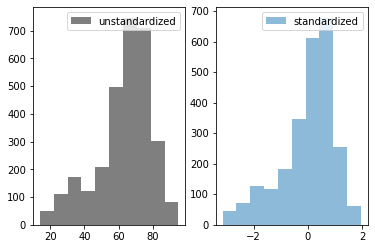

In [3]:
# Creating a class for the standardizer transformer.
class Standardizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Getting categorical variables, getting list of all non-categorical variables in this particular instance.
        # Note this is generalizable to inputs missing certain variables (question 4)
        categorical_variables = ['work_rate_att','work_rate_def','preferred_foot']
        model_continuous_vars = [column for column in X.columns if all(cat_var not in column for cat_var in categorical_variables)]
        
        # Standardizing all non-categorical variables, returning transformed data frame.
        standardization_steps=[('scaler', StandardScaler(), model_continuous_vars)]
        ct = ColumnTransformer(standardization_steps, remainder='passthrough')
        X = ct.fit_transform(X)
        return X

# Creating a column transformer to standardize non-categorical variables.
standardization_steps=[('scaler', Standardizer(), X.columns.tolist())]
ct = ColumnTransformer(standardization_steps)
standardized = ct.fit_transform(Xtrain)

# Turning standardized output into a data frame so that its columns are accessible.
standardized = pd.DataFrame(standardized, columns = X.columns.tolist())

# Creating a pipeline that standardizes non-categorical variables and runs a linear regression.
steps = [('scaler', ct), ('linear_regression', LinearRegression())]
pipe = Pipeline(steps)

# Plotting distributions of standardized & non-standardized stamina values
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(X.stamina, alpha=0.5, label='unstandardized', color='black')
ax1.legend()
ax2.hist(standardized.stamina, alpha=0.5, label='standardized')
ax2.legend()

'''Written answer: the plots appear to have the same distribution shape (minus some difference because of different bins for each plot), however the standardized plot is centred around 0 with a stdev of 1, whereas the unstandardized one is centred around the mean of stamina with a stdev of stamina\'s stdev.'''

## Question 3: Creating a Complex feature model using 2-nd Polynomial features (10 pts)
In this task, the training data consists of the quadratic terms and 2-way interactions of all features except one of standing_tackle, composure, and marking variable. <br> 
Create <b> four </b> different training sets:
* The first training set includes the quadratic terms and 2-way interactions of all the features. 
* The second/third/fourth training sets include all the features, their quadratic terms, and their 2-way interactions except the standing_tackle/composure/marking features. <br>

#### Hint: 
For the 2nd/3rd and 4th training sets, create the training sets without the aforementioned features and then apply polynomial expansion to the resultant sets. 
### Questions:
* How many linear terms are in each of the new feature set?
        In the feature set including all variables, there are 48 linear features--one for each feature.
        In the feature sets missing one variable, there are 47 linear variables for the same reason.
* How many squared terms are in each of the new feature set?
        In the feature set including all variables, there are 48 quadratic features--one for each feature.
        In the feature sets missing one variable, there are 47 linear variables for the same reason.
* How many interaction terms are in each of the new feature set? Give an example of one of the interaction terms. 
        There are nC2=n(n-1)/2 interaction terms in each feature set, given that there is an interaction set for each possible pair. For the set including all variables that is 48(47)/2 = 1128. 
        For the sets missing one variable each, that is 47(46)/2 = 1081.

In [4]:
# Creating a polynomial expander.
PT = PolynomialFeatures(degree = 2, include_bias=False)

# Getting column names for each of the outputs
cols = [None, 'standing_tackle', 'composure', 'marking']
quad_train = []
n_sets = 4

for i in range(n_sets):
    dropped = cols[i]
    # Dropping column if necessary, creating data frame with polynomially expanded values and column titles.
    # Note: These are unstandardized values, as the question did not ask for standardized values.
    if dropped == None:
        feature_names = PT.fit(Xtrain).get_feature_names(Xtrain.columns.tolist())
        quad_train.append(pd.DataFrame(PT.fit_transform(Xtrain), columns=feature_names))
    else:
        valid_data = Xtrain.drop(columns=cols[i])
        feature_names = PT.fit(valid_data).get_feature_names(valid_data.columns.tolist())
        quad_train.append(pd.DataFrame(PT.fit_transform(valid_data), columns=feature_names))
    
for training in quad_train:
    print(training.shape)

(2500, 1224)
(2500, 1175)
(2500, 1175)
(2500, 1175)


## Question 4: Evaluating the backward feature search (15 pts)
In this question, you have to use the pipeline created in question 2 and apply it to each of the training sets created in question 3. Use 10-fold cross validation to report the validation error on the training set using mean squared error as the metric. <br>
Show all the steps of the process and compare and analyze the results using the validation error reported. 

In [5]:
quad_model = []

# Creating a new pipeline that polynomially expands values after standardization.
# Note: This is a new pipeline because standardization after polynomial expansion is not possible because of column name inconsistencies.
quad_pipe =Pipeline([('scaler', Standardizer()), ('poly', PT),('linear_regression', LinearRegression())])

for i in range(n_sets):
    # Getting the training set of values with necessary columns dropped.
    if(i==0):
        train = Xtrain
    else:
        train = Xtrain.drop(columns=cols[i])
    quad_train[i] = train
    
    # Fitting the training set to the pipe that polynomially expands the standardized values. Saving the model.
    model = quad_pipe.fit(train, ytrain)
    quad_model.append(model)
    
quad_cv_score = []
for i in range(n_sets):
    # Calculating the CV score for each model and training set.
    cv_score = cross_val_score(quad_model[i], quad_train[i], ytrain, cv=10, scoring='neg_mean_squared_error')
    quad_cv_score.append(-cv_score.mean())
print(quad_cv_score)

[3.995927659800491, 3.693540317823291, 3.7473344578754904, 3.5986165091853826]


## Question 5: Applying Ridge Regression (10 pts)
Build a pipeline that performs scaling and fits the ridge regression on the data that includes the polynomial expansion of all the features. The penalization parameter is set to 0.5. Use the pipeline to report the validation error using mean square error metric. Use 10-fold cross validation. 

In [6]:
# Creating a pipeline that standardizes, polynomially expands the standardized value, then applies ridge regression with alpha=0.5
ridge_steps = [('scaler', Standardizer()), ('poly', PT), ('ridge_regression', Ridge(alpha=0.5))]
ridge_pipe = Pipeline(ridge_steps)

# Fitting the pipeline to the polynomial expansion of all the features (i.e on the complete training data). Reporting CV score
ridge_model = ridge_pipe.fit(Xtrain, ytrain)
ridge_cv_score = - cross_val_score(ridge_model, Xtrain, ytrain, cv=10, scoring = 'neg_mean_squared_error').mean()
print(ridge_cv_score)

2.785777156075923


## Question 6: Tune the Ridge coefficient for the 2nd-order model   (15 pts)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search going from $\lambda = \exp(-8), \cdots, \exp(6)$ in 15 evenly spaced increments on the log scale. Plot the mean squared error as a function of $\log(\lambda)$. 

### Questions: 

What is the best regularization parameter (actual not approximate)? 
* The best regularization parameter is $e^{5}$.

Why does the error increase as $\lambda \rightarrow 0?$  Why does the error increase when $\lambda \rightarrow \infty$?  Answer in terms of the bias variance trade off.
* As $\lambda$ approaches 0, there is no regularization and the coefficients can grow unconstrained. As a result there is a possibility these coefficients will lead to overfitting, and lead to a large variance in the data.
* As $\lambda$ approaches $\infty$, all of the coefficients will approach 0, leading to a poor class of function retrieved, which is not well fit to the training data, thus possessing a high bias.

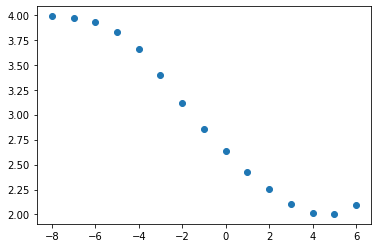

In [7]:
lam = np.exp(np.linspace(-8,6,15))
mse = np.zeros(len(lam))

# Iterating through each different lambda value.
for i in range(len(lam)):
    # Creating a temporary pipeline that standardizes, polynomially expands, and runs a ridge regression with the current value of lambda.
    temp_steps = [('scaler', Standardizer()), ('poly', PT), ('ridge_regression', Ridge(alpha=lam[i]))]
    temp_pipe = Pipeline(temp_steps)
    temp_model = temp_pipe.fit(Xtrain, ytrain)
    
    # Recording the scores for each lambda.
    cv_scores = cross_val_score(temp_model, Xtrain, ytrain, cv=10, scoring = 'neg_mean_squared_error')
    mse[i] = -cv_scores.mean()
    
# Outputting a scatterplot of lambda values.
plt.scatter(np.log(lam), mse)


### Question 7: Test error  (10 pts)
Now test how the ridge model, fitted to the whole training set, performs on the test data set. 


Report the following:

* The mean squared error on the test data - along with the 95% confidence interval, determined with the central limit theorem. 
* The proportion of the variance explained by your model - along wth a 95% confidence interval.

In [12]:
# Creating a bootstrap function for r2
def r2_dist(Xtest, ytest, best_ridge_model, columns, numboot=100):
    n = len(Xtest)
    r2_vals = np.zeros(numboot)
    
    # Concatenating training and testing data into one such that the overalls correspond with their inputs. Using a data frame for easy column access/manipulation.
    samp = pd.DataFrame(np.c_[Xtest, ytest], columns=columns)
    
    for i in range(numboot):
        # Bootstrapping random samples, calculating r2.
        d = samp.sample(n, replace=True)
        rsq = best_ridge_model.score(d.drop(columns="overall"), d.overall)
        r2_vals[i] = rsq
    return r2_vals


# Get a ridge model that's fit to the training data with the best alpha.

best_ridge_pipeline = Pipeline([('scaler', Standardizer()), ('poly', PT), ('ridge_regression', Ridge(alpha=np.exp(5)))])
best_ridge_model = best_ridge_pipeline.fit(Xtrain,ytrain)
# Predict and get the errors
yp = best_ridge_model.predict(Xtest)
squared_errors = (ytest - yp)**2

# Calculate MSE and confidence interval distance
mse = np.mean(squared_errors)
interval_distance = 1.96 * np.std(squared_errors) / np.sqrt(len(squared_errors))

# Bootstrapping r2 values. Getting the mean and confidence interval distance.
r2_vals = r2_dist(Xtest, ytest, best_ridge_model, X.columns.tolist()+["overall"])
rsq = np.mean(r2_vals)
r2sqe = np.std(r2_vals)

rsq_interval_distance = 1.96 * r2sqe / np.sqrt(len(r2_vals))

print("ERROR\nMean: {}, confidence interval: {}\n".format(mse, (mse-interval_distance, mse+interval_distance)))
print("R2\nMean: {}, confidence interval: {}".format(rsq, (rsq-rsq_interval_distance, rsq+rsq_interval_distance)))

ERROR
Mean: 2.057337635208312, confidence interval: (1.7179112324153898, 2.3967640380012343)

R2
Mean: 0.9557158624498421, confidence interval: (0.9543464048916879, 0.9570853200079963)


## Question 8: Analyzing Ridge Coefficients (15 pts)
In this question, you are first required to extract all the coefficients of the standing tackle, composure and marking features from the best model of question 7. After that, calculate the mean of the coefficients of the aforementioned features and analyze the results. Based on these observations, draw conclusions about the results in question 4. 

In [32]:
extract_indices = {}
extract_coefs = {}
quad_columns = PT.fit(Xtrain).get_feature_names(Xtrain.columns)
quad_coefs = best_ridge_model.named_steps['ridge_regression'].coef_
for col in cols:
    if col!=None:
        indices=[]
        coefs = []
        for i in range(len(quad_columns)):
            if col in quad_columns[i]:
                indices.append(i)
                coefs.append(quad_coefs[i])
        extract_indices[col] = indices
        extract_coefs[col] = coefs
mean_coefs = [(col, np.mean(extract_coefs[col])) for col in extract_coefs.keys()]
print(mean_coefs)
print("\n\nWritten answer: because marking has the lowest coefficient here on standardized variables, it appears it \
 has the highest degree of collinearity while not providing much insight on its own. As a result, removing it and all its interactions from the regression \
 reduced the error the most, as a more independent set of predictors was present. However, we see that standing \
 tackle has a higher coefficient than composure, despite the fact that removing standing tackle improves the CV \
 error more. This likely means that although standing tackle has a high degree of multicollinearity, it is a more \
 important predictor variable on its own, so other predictors would go to zero while it remains higher.")

[('standing_tackle', 0.033449904588563915), ('composure', 0.01534353355669744), ('marking', 0.014551499170463774)]


Written answer: because marking has the lowest coefficient here on standardized variables, it appears it  has the highest degree of collinearity. As a result, removing it and all its interactions from the regression  reduced the error the most, as a more independent set of predictors was present. However, we see that standing  tackle has a higher coefficient than composure, despite the fact that removing standing tackle improves the CV  error more. This likely means that although standing tackle has a high degree of multicollinearity, it is a more  important predictor variable on its own, so other predictors would go to zero while it remains higher.


## Question 9: Lasso Regression (10 pts)
Let us assume that you are building a linear regression model using only three features: standing tackle, marking, and composure to predict a player's overall rating. Based on the results of question 8, what do you think will be the features' coefficients while applying the lasso regression optimization? Answer in no more than 5 sentences.

Answer: It is likely that standing tackle coefficient would be non-zero, while the others would be 0. This is because while ridge regression looks to make all coefficients small to a certain degree, lasso regression looks to make as many coefficients as possible 0. Since standing tackle has the highest ridge coefficient of the three, that means it performs the best in spite of its multicollinearity. As a result, it is best to use only standing tackle and not the other two to reduce computational complexity.